In [2]:
import os
import sys
import numpy as np
# sys.path.append('../')
import spikeoutputs as so
import spikeplots as sp
import celltype_io as ctio
import importlib
importlib.reload(so)
importlib.reload(sp)
importlib.reload(ctio)

import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import numpy as np

import visionloader as vl
import os

import seaborn as sns

In [3]:
str_experiment = '20230322C'
str_algo = 'kilosort2'
str_chunk = 'chunk1'

str_analysis_dir = '/Volumes/SrinDrive/'

str_exp_dir = os.path.join(str_analysis_dir, str_experiment, str_chunk, str_algo)
str_class = 'kilosort2.classification.txt'

str_params = 'kilosort2.params'

d_paths = {'str_experiment': str_experiment, 'paramsfile': os.path.join(str_exp_dir, str_params), 
           'dataset_name': str_algo, 'str_protocol': 'noise', 
           'str_classification': os.path.join(str_exp_dir, str_class), 'str_chunk': str_chunk}

data = so.SpikeOutputs(**d_paths)
data.load_sta()

In [4]:
str_datafile = '/Users/srinidhienaidu/Desktop/Rieke Lab Data/20230322C_kilosort2_data000_data001_data002_data003_data004__spot.p'

with open(str_datafile, "rb") as f:
   d_data = pickle.load(f)

# vcd = vl.load_vision_data(str_datafile, sort_algorithm, include_params = True, include_neurons = True)

In [5]:
spike_array = d_data['spike_array']
spike_dict = d_data['spike_dict']
spot_intensity = d_data['spot_intensity']
avg_psth = d_data['avg_psth']
cluster_id = list(spike_dict.keys())
pre_pts = d_data['pre_pts'][0]
stim_pts = d_data['stim_pts'][0]
tail_pts = d_data['tail_pts'][0]
bin_rate = d_data['bin_rate']

In [6]:
data.d_sta[1]
data.types.print_summary(b_only_main_types=True)

Total number of cells: 879
No OffP
No OffM
Number of OnP: 186
Number of OnM: 253
No SBC


In [1]:
OnP_ID = data.types.d_main_IDs['OnP']
OnP_ID_intersect = np.intersect1d([OnP_ID], [cluster_id])

OnP_len_intersected = len(OnP_ID_intersect)
OnP_distances = np.zeros((OnP_len_intersected, OnP_len_intersected))

NameError: name 'data' is not defined

In [8]:
for i in range(OnP_len_intersected): 
    for j in range(OnP_len_intersected):
        
        id_1 = OnP_ID_intersect[i]
        id_2 = OnP_ID_intersect[j]

        x1 = data.d_sta[id_1]['x0']
        y1 = data.d_sta[id_1]['y0']
        point1 = np.array((x1, y1))

        x2 = data.d_sta[id_2]['x0']
        y2 = data.d_sta[id_2]['y0']
        point2 = np.array((x2, y2))

        OnP_distances[i, j] = np.linalg.norm(point1 - point2)

In [9]:
psth_cell_indx = []
OnP_avg_psth = []

for i in range(len(cluster_id)):
    for j in OnP_ID_intersect:
        if cluster_id[i] == j: 
            psth_cell_indx.append(i)

for i in psth_cell_indx:
    OnP_avg_psth.append(avg_psth[i])

In [10]:
OnP_response_correlations = np.zeros((len(OnP_avg_psth), len(OnP_avg_psth)))

In [11]:
for i in range(len(OnP_avg_psth)): 
    for j in range(len(OnP_avg_psth)):
        corr = np.corrcoef(OnP_avg_psth[i], OnP_avg_psth[j])
        corr_val = corr[0, 1]
        OnP_response_correlations[i, j] = corr_val

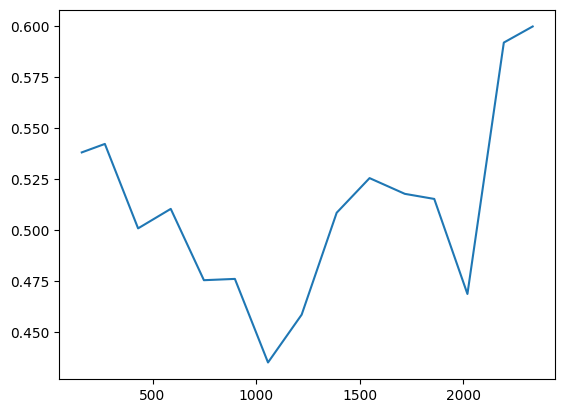

In [37]:
OnP_response_correlations.shape

# more bin edges (increase num_bins)
# calculating the standard deviatino in each of the bins 
# mulitply x axis by 30 to go from stixel to microns


num_bins = 15
bin_edges=np.linspace(1,np.max(OnP_distances)+1,num_bins+1)
bin_count = np.zeros((num_bins))
avg_distance = np.zeros((num_bins))
avg_correlation = np.zeros((num_bins))

d_flat= OnP_distances.flatten()
c_flat = OnP_response_correlations.flatten()

for i in range(num_bins):
    idx= np.where(np.logical_and(d_flat>bin_edges[i], d_flat<=bin_edges[i+1]))[0]
    avg_distance[i] = np.mean(d_flat[idx])
    avg_correlation[i] = np.mean(c_flat[idx])

plt.plot(avg_distance*30, avg_correlation)


In [12]:
U_OnP_distances = np.triu(OnP_distances)
flattened_distances = OnP_distances.flatten()
U_OnP_response_correlations = np.triu(OnP_response_correlations)
flattened_correlations = OnP_response_correlations.flatten()

mask1 = np.ones((len(OnP_avg_psth), len(OnP_avg_psth)))
mask = np.triu(mask1, 1)

mask = mask.flatten().astype('bool')

sliced_distances = U_OnP_distances.flatten()[mask]
sliced_correlations = U_OnP_response_correlations.flatten()[mask]


Text(0, 0.5, 'correlations')

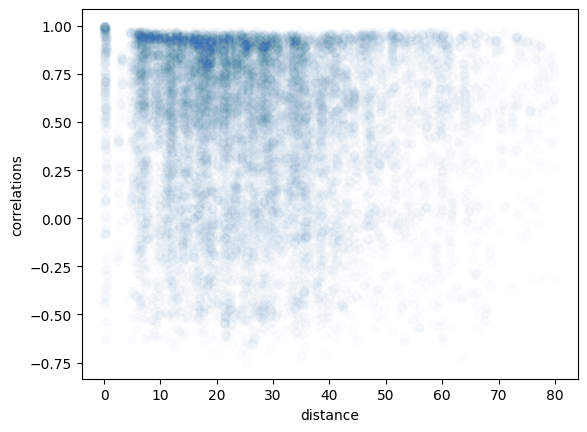

In [13]:
plt.scatter(sliced_distances, sliced_correlations, alpha = 0.01)
plt.xlabel('distance')
plt.ylabel('correlations')

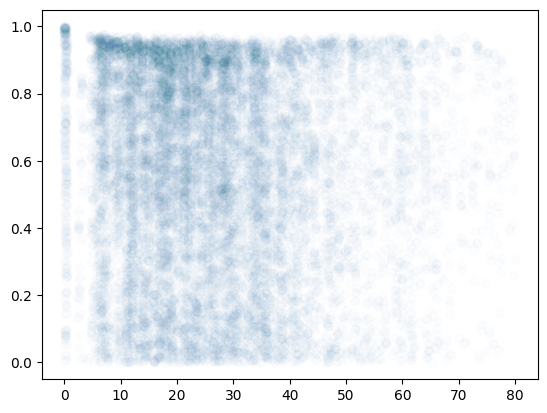

In [27]:
# axs = sp.plot_type_rfs(data)
# axs = sp.plot_type_tcs(data)

abs_correlations = abs(sliced_correlations)

plt.scatter(sliced_distances, abs_correlations, alpha = 0.01)


In [20]:
# import celltype_io as ctio

# # Get index of OnP cells
# cell_ids = data.types.d_main_IDs['OnP']

# cell_idxs = ctio.map_ids_to_idx(cell_ids, data.ARR_CELL_IDS)


In [21]:
# for idx_cell in cell_idxs:
#     # Remove 0,0 points and plot closed polygon
#     x = matdata['hull_vertices'][idx_cell, :, 0]
#     y = matdata['hull_vertices'][idx_cell, :, 1]
#     y = -y
#     # Remove points where both x and y are 0
#     idx_nonzero = np.argwhere((x != 0) & (y != 0))[:,0]
#     x = x[idx_nonzero]
#     y = y[idx_nonzero]

#     plt.fill(x, y, fill=True, alpha=0.5, edgecolor='k', linewidth=2, color='C1')

NameError: name 'matdata' is not defined

In [ ]:
}